In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt
import glob


In [2]:
WEAK = False

x_len = 5000
t_len = 1200

xs = np.arange(x_len)
dt = 1

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]  

if WEAK:
    X, T = np.meshgrid(xs, np.arange(t_len))
    XT = np.asarray([X, T]).T

    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=4,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=1000,
    )
else:
    
    pde_lib = ps.PDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=4,
        spatial_grid=xs,
        include_bias=True,
        is_uniform=True,
    )
    

## Unfiltered

In [3]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

init = 11
final= 12

time_subsample = 10
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
working_dat = full_dat/np.std(full_dat)


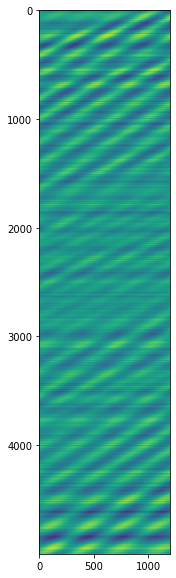

In [4]:
plt.figure(figsize=(12,10))
plt.imshow(full_dat)
plt.show()

In [5]:

working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


In [6]:
working_dat.shape

(5000, 1200, 1)

### Dataset 1

In [7]:
thresh = 1e-3
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.001))

In [8]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.001
(x0)' = 0.009 x0_1 + 0.005 x0_111


In [9]:
thresh = 1e-5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-05))

In [10]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-05
(x0)' = 0.009 x0_1 + 0.005 x0_111 + -0.001 x0x0_1


In [11]:
thresh = 1e-8
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-08))

In [12]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-08
(x0)' = 0.009 x0_1 + 0.005 x0_111 + -0.001 x0x0_1


### Dataset 2

In [13]:
time_subsample = 10
full_dat = np.zeros((5000,1200))

k = 0
for i in np.arange(21,22):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    


In [14]:
working_dat = full_dat/np.std(full_dat)#*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


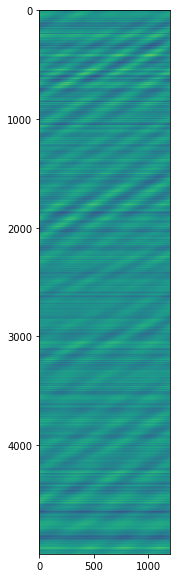

In [15]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0], vmin=-5.,vmax=5.)
plt.show()

In [19]:
thresh = 1e-4
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.0001))

In [20]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.0001
(x0)' = 0.001 x0_1 + 0.001 x0_111


In [21]:
thresh = 1e-5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-05))

In [22]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-05
(x0)' = 0.001 x0_1 + 0.001 x0_111


In [23]:
thresh = 1e-8
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-08))

In [24]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-08
(x0)' = 0.001 x0_1 + 0.001 x0_111


## Gaussian Filtered



In [25]:
file_list = glob.glob("/home/ldoyle/notebooks/rad_10_smooth_data/*")

In [26]:
# n = 1.4682
# L = 51.04762
working_dat = np.zeros((5000,1200))
b=0
for q in np.arange(1):
#     if b==0:
#         working_dat = np.load(file_list[q])
#         b=1
#     else:
#         working_dat = np.hstack((working_dat, np.load(file_list[q])))
    working_dat[:,q*(1200):(q+1)*1200] = np.load(file_list[q])[:,::10]
        
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

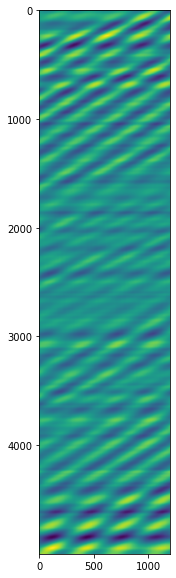

In [27]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [28]:
xs = np.arange(working_dat.shape[0])
print(xs.shape)

(5000,)


### Dataset 1

In [53]:
thresh = 0.378
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.378))

In [54]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.378
(x0)' = -12.658 x0_111 + 0.743 x0x0x0_111


In [41]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [42]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.429 x0_1 + 18.845 x0_111 + 0.923 x0x0x0_111


In [51]:
thresh = 5e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [52]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.429 x0_1 + -0.026 x0_11 + 18.832 x0_111 + -0.773 x0x0_111 + 0.885 x0x0x0_111


### Dataset 2

In [55]:
working_dat = np.zeros((5000,1200))
b=0
for q in np.arange(10,11):

    working_dat[:,b*(1200):(b+1)*1200] = np.load(file_list[q])[:,::10]
    b+=1
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

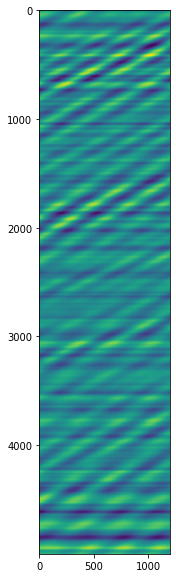

In [56]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [65]:
thresh = 0.2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.2))

In [66]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.2
(x0)' = 0.297 x0_1 + 13.155 x0_111 + 0.241 x0x0x0_111


In [67]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [68]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.297 x0_1 + 13.155 x0_111 + 0.241 x0x0x0_111


In [69]:
thresh = 5e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [70]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.297 x0_1 + 13.153 x0_111 + -0.274 x0x0_111 + 0.232 x0x0x0_111


## Drift Removal Load

In [71]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_11.npy")[:,:12000:10]
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])

In [73]:
thresh = 5e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [74]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.214 x0_1 + 0.098 x0_111


In [75]:
thresh = 1e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [76]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.227 x0_1 + 0.102 x0_111 + -0.031 x0x0x0_1 + -0.011 x0x0x0_111


In [77]:
thresh = 1e-3
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.001))

In [78]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.001
(x0)' = 0.227 x0_1 + 0.001 x0_11 + 0.102 x0_111 + 0.002 x0x0_1 + -0.031 x0x0x0_1 + 0.001 x0x0_111 + -0.011 x0x0x0_111


### Dataset 2

In [79]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_21.npy")[:,:12000:10]
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])

In [80]:
thresh = 5e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [81]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.224 x0_1 + 0.106 x0_111


In [82]:
thresh = 1e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [83]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.228 x0_1 + 0.107 x0_111 + -0.021 x0x0x0_1 + -0.005 x0x0x0_111


In [84]:
thresh = 1e-3
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.001))

In [85]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.001
(x0)' = 0.228 x0_1 + 0.010 x0_11 + 0.107 x0_111 + 0.003 x0_1111 + 0.004 x0x0_1 + -0.022 x0x0x0_1 + -0.005 x0x0_11 + -0.012 x0x0x0_11 + 0.003 x0x0_111 + -0.006 x0x0x0_111 + -0.002 x0x0_1111 + -0.004 x0x0x0_1111


## Multifilt

In [86]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/smoothed_decimated_normalized_5_min_start_11.npy")[:,:1200]
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


### Dataset 1

In [87]:
thresh = 0.5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.5))

In [88]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.5
(x0)' = 0.581 x0_1 + 3.972 x0_111


In [89]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [90]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.581 x0_1 + 3.894 x0_111 + 0.176 x0x0x0_111


In [91]:
thresh = 0.02
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.02))

In [92]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.02
(x0)' = 0.594 x0_1 + 4.000 x0_111 + -0.035 x0x0x0_1 + -0.118 x0x0x0_111


### Dataset 2

In [93]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/smoothed_decimated_normalized_5_min_start_21.npy")[:,:1200]
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


In [94]:
thresh = 0.5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.5))

In [95]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.5
(x0)' = 0.540 x0_1


In [96]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [97]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.564 x0_1 + 3.838 x0_111


In [98]:
thresh = 0.05
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [99]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.571 x0_1 + 3.867 x0_111 + -0.046 x0x0x0_1 + -0.209 x0x0x0_111


In [100]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f4d06c05dc0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [101]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.571 x0_1 + 3.867 x0_111 + -0.046 x0x0x0_1 + -0.209 x0x0x0_111
